# Kickstarter ML Project

## Preparation

In [25]:
import pandas as pd
import numpy as np
import glob

import sweetviz as sv
import json

### Load Data

In [63]:
# Load csv's and merge to a single dataframe

#path = "/Users/bur.oez/neuefische/Kickstarter-ML-Project/data/*.csv" # Burak's path
path = "data/*.csv" # Christian's path
#path = ".../*.csv"" # Matthias's path

all_files = glob.glob(path)
df_raw = pd.concat((pd.read_csv(f) for f in all_files))

### Overview

In [27]:
## Execute Sweetviz 
#my_report = sv.analyze(df_raw)
#my_report.show_html() # Default arguments will generate to "SWEETVIZ_REPORT.html"

In [64]:
df_raw.columns

Index(['backers_count', 'blurb', 'category', 'converted_pledged_amount',
       'country', 'created_at', 'creator', 'currency', 'currency_symbol',
       'currency_trailing_code', 'current_currency', 'deadline',
       'disable_communication', 'friends', 'fx_rate', 'goal', 'id',
       'is_backing', 'is_starrable', 'is_starred', 'launched_at', 'location',
       'name', 'permissions', 'photo', 'pledged', 'profile', 'slug',
       'source_url', 'spotlight', 'staff_pick', 'state', 'state_changed_at',
       'static_usd_rate', 'urls', 'usd_pledged', 'usd_type'],
      dtype='object')

## Data Cleaning

For safety, we operate on a copy of the data frame.

In [65]:
df = df_raw.copy()

For a basic feature analysis, we may focus on easily accessible features. Consequently, we drop the cols
- `blurb`, `slug`, `name` and `photo`, because they might only be exploitable through a semantic or context analysis,
- `currency_symbol`, `currency_trailing_code`, because they are redundant,
- `friends`, `is_starrable` and `permission`, because they do not contain any information,
- `disable_communication`, `is_backing` and `is_starred`, because they have an entry only for the same 300 data points and it is questionable whether the missing entries may be treated as one category; later on we might try this with one of them and drop the other two,  
- `urls`, `source_url` and `profile` because they do not contain additional information.
- `state_changed_at`, `spotlight` and `staff_pick` will be dropped, because the creator does not know them in adcvance,
- `created_at`, `launched_at` and `deadline` will be kept to calculate time-deltas for potential new features.

In [67]:
# dropping columns
df = df.drop(["blurb", "slug", "name", "photo", "currency_symbol", "currency_trailing_code", "state_changed_at",
              "friends", "permissions", "disable_communication", "is_backing", "is_starred","urls", 
              "source_url", "profile", "usd_type", "spotlight", "staff_pick", "is_starrable"], axis = 1)
df.head()

,backers_count,category,converted_pledged_amount,country,created_at,creator,currency,current_currency,deadline,fx_rate,goal,id,launched_at,location,pledged,state,static_usd_rate,usd_pledged
0,315,"{""id"":266,""name"":""Footwear"",""slug"":""fashion/fo...",28645,US,1541459205,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",USD,USD,1552539775,1.000000,28000.0,2108505034,1548223375,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",28645.0,live,1.000000,28645.000000
1,47,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",1950,US,1501684093,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",USD,USD,1504976459,1.000000,1000.0,928751314,1502384459,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",1950.0,successful,1.000000,1950.000000
2,271,"{""id"":43,""name"":""Rock"",""slug"":""music/rock"",""po...",22404,US,1348987533,"{""id"":323849677,""name"":""Electra"",""is_registere...",USD,USD,1371013395,1.000000,15000.0,928014092,1368421395,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...",22404.0,successful,1.000000,22404.000000
3,3,"{""id"":273,""name"":""Playing Cards"",""slug"":""games...",165,GB,1483780271,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",GBP,USD,1489425776,1.308394,10000.0,596091328,1484245376,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",136.0,failed,1.216066,165.384934
4,3,"{""id"":48,""name"":""Nonfiction"",""slug"":""publishin...",2820,US,1354817071,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",USD,USD,1357763527,1.000000,2800.0,998516049,1355171527,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",2820.0,successful,1.000000,2820.000000


Extract field and subfield ids from `category` (id and parent_id):

In [68]:
import ast
df.category =[ ast.literal_eval(x) for x in df.iloc[:,df.columns.tolist().index("category")]]

In [69]:
# checking which rows do not contain "parent_id" inside category dictionary
cat_list_parent_id = np.array(["parent_id" not in df.category.iloc[x].keys() for x in range(0,len(df.category))])
cat_list_parent_id.sum()

9041

In [33]:
df[cat_list_parent_id].iloc[0:3]

,backers_count,category,converted_pledged_amount,country,created_at,currency,current_currency,deadline,fx_rate,goal,id,launched_at,location,pledged,state,state_changed_at,static_usd_rate,usd_pledged
7,33,"{'id': 14, 'name': 'Music', 'slug': 'music', '...",660,US,1546965483,USD,USD,1550067305,1.000000,400.0,1481360049,1547475305,"{""id"":2430903,""name"":""Kaysville"",""slug"":""kaysv...",660.0,successful,1550067307,1.000000,660.000000
25,74,"{'id': 15, 'name': 'Photography', 'slug': 'pho...",2808,GB,1542202969,GBP,USD,1544200381,1.308394,2000.0,865110410,1542385981,"{""id"":12056,""name"":""Bath"",""slug"":""bath-gb"",""sh...",2199.0,successful,1544200381,1.301163,2861.258251
27,41,"{'id': 9, 'name': 'Fashion', 'slug': 'fashion'...",21161,GB,1551345787,GBP,CAD,1554490790,1.748586,20000.0,1889386358,1551898790,"{""id"":40611,""name"":""Winchester"",""slug"":""winche...",12102.0,live,1551898791,1.315996,15926.177904


In [70]:
df.category.iloc[0]

{'id': 266,
 'name': 'Footwear',
 'slug': 'fashion/footwear',
 'position': 5,
 'parent_id': 9,
 'color': 16752598,
 'urls': {'web': {'discover': 'http://www.kickstarter.com/discover/categories/fashion/footwear'}}}

The `id` column represents each subcategory. `parent_id` represents each parent category, since the values for `id` start after `parent_id` values, we will use `id` to seperate each project into categories.

e `id` column represents each subcategory. `parent_id` represents each parent category, since the values for `id` start after `parent_id` values, we will use `id` to seperate each project into categories.

To projects without proper subcategorisation the `parent_id` is assigned. In addition `slug`is added for increased readability.

In [71]:
df["cat_id"] = [df.category.iloc[x]["id"] for x in range(0,len(df.category))]
df["slug"] = [df.category.iloc[x]["slug"] for x in range(0,len(df.category))]
categories = df.pop("category")

In [72]:
df.head(3)
print(df.shape)

(209222, 19)


In [73]:
# check if currency - USD conversion with fx_rate and static_usd_rate matches usd_pledged value
print("pledged * static_usd_rate == usd_pledged")
print(df.eval("pledged * static_usd_rate == usd_pledged").value_counts())
print("pledged * fx_rate == usd_pledged")
print(df.eval("pledged * fx_rate == usd_pledged").value_counts())
print("converted_pledged_amount == usd_pledged")
print(df.eval("converted_pledged_amount == usd_pledged").value_counts())
print("pledged * static_usd_rate == converted_pledged_amount")
print(df.eval("pledged * static_usd_rate == converted_pledged_amount").value_counts())
print("pledged * fx_rate == converted_pledged_amount")
print(df.eval("pledged * fx_rate == converted_pledged_amount").value_counts())

pledged * static_usd_rate == usd_pledged
True     193838
False     15384
dtype: int64
pledged * fx_rate == usd_pledged
True     153961
False     55261
dtype: int64
converted_pledged_amount == usd_pledged
True     140490
False     68732
dtype: int64
pledged * static_usd_rate == converted_pledged_amount
True     140490
False     68732
dtype: int64
pledged * fx_rate == converted_pledged_amount
True     140473
False     68749
dtype: int64


In [74]:
print(df.eval("converted_pledged_amount == pledged + usd_pledged").value_counts())

False    190860
True      18362
dtype: int64


The values in `usd_pledged` do not match with the conversion of `pledged` using `fx_rate` or `static_usd_rate`. 

We decided to take the max value for these columns as the correct amount.

In [75]:
# checking whether pledged, usd_pledged or converted_pledged_amount has the highest values
df["max_pledged"] = [max(df.pledged.iloc[x], 
df.usd_pledged.iloc[x], 
df.converted_pledged_amount.iloc[x]) for x in range(0,len(df))]
df = df.drop(["usd_pledged", "pledged", "converted_pledged_amount"], axis = 1)

In [76]:
# in addition all other currency info can also be dropped
df = df.drop(["static_usd_rate", "fx_rate", "currency", "current_currency"], axis = 1)

In [77]:
# set checkpoint
df2 = df.copy()
df.head(2)
print(df.shape)

(209222, 13)


Now we will check whether `live` projects have met their goal and can be considered as `succesful`


In [78]:
df.loc[df['max_pledged'] >= df.goal, 'state'] = "successful"
#check whether there are live:successsful projects left
df.query("state == 'live' and max_pledged >= goal").state

Series([], Name: state, dtype: object)

In [79]:
#df = df2.copy()
df.shape

(209222, 13)

Now we will drop all entries, which are not `successful` or `failed`


In [80]:
df.state.value_counts()

successful    119839
failed         75108
canceled        8456
live            5277
suspended        542
Name: state, dtype: int64

In [81]:
df = df[df.state != "canceled"]
df = df[df.state != "suspended"]
df = df[df.state != "live"]
df.state.unique()

array(['successful', 'failed'], dtype=object)

In [82]:
df.shape

(194947, 13)

Sort `countries` into categories US, NA, SEA, GB, ANZ, JP, EU:

In [83]:
pd.unique(df.country)

array(['US', 'GB', 'FR', 'AU', 'NZ', 'ES', 'IT', 'NO', 'NL', 'CA', 'SG',
       'MX', 'SE', 'IE', 'DE', 'BE', 'HK', 'AT', 'JP', 'DK', 'CH', 'LU'],
      dtype=object)

In [48]:
df.country.replace({'HK':"SEA", 'NL':"EU", 'AU':"ANZ", 'DE':"EU", "CA":"NA", 'SE':"EU",
                    'BE':"EU", 'MX':"NA", 'CH':"EU", 'SG':"SEA", 'FR':"EU", 'IT':"EU",
                    'DK':"EU", 'LU':"EU", 'NO':"EU", 'ES':"EU", 'IE':"EU", 'NZ':"ANZ", 
                    'AT':"EU"}, inplace = True)

Turn entries of `created_at`, `launched`, `deadline` into datetime:

In [85]:
df.created_at = pd.to_datetime(df.iloc[:,df.columns.tolist().index("created_at")],unit='s')
df.launched_at = pd.to_datetime(df.iloc[:,df.columns.tolist().index("launched_at")],unit='s')
df.deadline = pd.to_datetime(df.iloc[:,df.columns.tolist().index("deadline")],unit='s')
#df.state_changed_at = pd.to_datetime(df.iloc[:,df.columns.tolist().index("state_changed_at")],unit='s')
df.head()

,backers_count,country,created_at,creator,deadline,goal,id,launched_at,location,state,cat_id,slug,max_pledged
0,315,US,2018-11-05 23:06:45,"{""id"":2094277840,""name"":""Lucy Conroy"",""slug"":""...",2019-03-14 05:02:55,28000.0,2108505034,2019-01-23 06:02:55,"{""id"":2462429,""name"":""Novato"",""slug"":""novato-c...",successful,266,fashion/footwear,28645.000000
1,47,US,2017-08-02 14:28:13,"{""id"":723886115,""name"":""Lisa Vollrath"",""slug"":...",2017-09-09 17:00:59,1000.0,928751314,2017-08-10 17:00:59,"{""id"":2400549,""name"":""Euless"",""slug"":""euless-t...",successful,273,games/playing cards,1950.000000
2,271,US,2012-09-30 06:45:33,"{""id"":323849677,""name"":""Electra"",""is_registere...",2013-06-12 05:03:15,15000.0,928014092,2013-05-13 05:03:15,"{""id"":2423474,""name"":""Hollywood"",""slug"":""holly...",successful,43,music/rock,22404.000000
3,3,GB,2017-01-07 09:11:11,"{""id"":196281496,""name"":""Artur Ordijanc (delete...",2017-03-13 17:22:56,10000.0,596091328,2017-01-12 18:22:56,"{""id"":475457,""name"":""Kaunas"",""slug"":""kaunas-ka...",failed,273,games/playing cards,165.384934
4,3,US,2012-12-06 18:04:31,"{""id"":1178460181,""name"":""Dawn Johnston"",""is_re...",2013-01-09 20:32:07,2800.0,998516049,2012-12-10 20:32:07,"{""id"":2507703,""name"":""Traverse City"",""slug"":""t...",successful,48,publishing/nonfiction,2820.000000


In [86]:
df.shape

(194947, 13)

In [87]:
# set checkpoint
df2 = df.copy()

Check for `id` copies and remove if they refer to the same data point: multiplicities of entries:

In [88]:
print(*df.id.value_counts().unique())

3 2 1


List of multiply used `id` entries:

In [89]:
dic = df.id.value_counts()
multiples = np.array([key for key in dic.keys() if dic[key] > 1])
len(multiples)

24596

They don't differ in any features, except one.

In [55]:
#for id in multiples:
#    print((id, [c for c in df.columns if df.query('id == '+str(id))[c].nunique() != 1]))


In that case, only one of the rows with the same `id` entry need to be kept.

In [90]:
df.drop_duplicates(subset = "id", keep = "first", inplace = True)

In [91]:
df.shape

(170350, 13)

Now we will take a look at `location` and try to extract some meaningful information.

Fist we will drop NaN rows and then convert the `json-str` into a dictonary to extract keys and values.

In [92]:
df.location.isnull().sum()

213

In [93]:
df.dropna(axis = 0, subset = ["location"], inplace = True)

In [94]:
df.location =[json.loads(x) for x in df.location]

In [95]:
df["location_type"] = [df.location.iloc[x]["type"] for x in range(0,len(df.location))]
df["location_city"] = [df.location.iloc[x]["short_name"] for x in range(0,len(df.location))]
df["location_state"] = [df.location.iloc[x]["state"] for x in range(0,len(df.location))]

In [96]:
df.location_type.value_counts()

Town             157752
County             6433
Suburb             4303
LocalAdmin          992
Zip                 412
Island              209
Country              17
Miscellaneous        15
Estate                4
Name: location_type, dtype: int64

Remaining questions:
- What to do with location? Extract cities and try to assign some score to each? To test this, extract a few big cities and check for correlation with target.

In [97]:
df.shape

(170137, 16)

-------

## Matthias

### Location score

In [98]:
dic = {x:0 for x in df.location_city}

dic.update(df.query('state == 1').location_city.value_counts().to_dict())
df['location_score'] = df.location_city.replace(dic)

df['location_score'] = [max(0, x-1) for x in df.location_score]

### Goal cutoff and log

The distribution of `goal` is sporadic:

In [99]:
df.goal.max(), df.goal.min(), df.goal.mean(), df.goal.median(), df.goal.std()

(100000000.0, 0.01, 48167.901415212444, 5000.0, 1155893.9864497301)

Let us see how many data points get lost for certain `goal` cutoffs:

In [207]:
print('cutoff = 10,000,000:', df.query('goal > 10000000').goal.count())
print('cutoff = 5,000,000:', df.query('goal > 5000000').goal.count())
print('cutoff = 2,000,000:', df.query('goal > 2000000').goal.count())
print('cutoff = 1,000,000:', df.query('goal > 1000000').goal.count())

cutoff = 10,000,000: 90
cutoff = 5,000,000: 190
cutoff = 2,000,000: 416
cutoff = 1,000,000: 720


We cut off at 10,000,000:

In [100]:
df = df.query('goal < 10000001')

In addition, we take the log:

In [101]:
df.goal = df.eval('log(goal)')

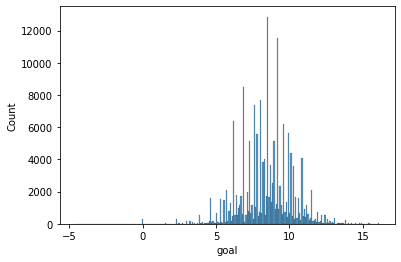

In [103]:
import seaborn as sns
sns.histplot(df.goal);

### Success rate

In [104]:
df['creator_id'] = [x[x.find(':')+1 : x.find(',')] for x in df.creator]

dic_suc = {id:0 for id in df.creator_id.unique()}
dic_fai = {id:0 for id in df.creator_id.unique()}
dic_suc.update(df.query('state == "successful"').creator_id.value_counts().to_dict())
dic_fai.update(df.query('state == "failed"').creator_id.value_counts().to_dict())

df['projects_successful'] = df.creator_id
df['projects_failed'] = df.creator_id

In [105]:
df.projects_successful.replace(dic_suc, inplace=True)
df.projects_failed.replace(dic_fai, inplace=True)

In [261]:
df['projects_successful_nm'] = [max(0, x-1) for x in df.projects_successful]
df['projects_failed_nm'] = [max(0, x-1) for x in df.projects_failed]

Drop `creator_id`:

In [265]:
df.drop('creator_id', axis=1, inplace=True)

In [262]:
df.projects_successful_nm, df.projects_failed_nm 

(1       6
 2       0
 3       0
 4       0
 5       0
        ..
 3786    0
 3788    0
 3789    0
 3790    1
 3791    0
 Name: projects_successful_nm, Length: 168699, dtype: int64,
 1       0
 2       0
 3       1
 4       0
 5       0
        ..
 3786    0
 3788    0
 3789    0
 3790    0
 3791    0
 Name: projects_failed_nm, Length: 168699, dtype: int64)

### Gender

In [113]:
df['creator_name'] = [x[x.find('":"')+3 : x.find('","')].split(' ')[0].lower() for x in df.creator]

In [114]:
males = pd.read_csv('male.txt', sep='\n')
females = pd.read_csv('female.txt', sep='\n')

dic_names = {x.lower():1 for x in males['# List of common male names.'].iloc[4:]}
dic_names.update({x.lower():0 for x in females['# List of common female names.'].iloc[4:]})

dic = {x:2 for x in df.creator_name}
dic.update(dic_names)

In [116]:
df['gender'] = df.creator_name.replace(dic)

### Final shape

In [118]:
df.shape

(170070, 22)

In [119]:
df.columns

Index(['backers_count', 'country', 'created_at', 'creator', 'deadline', 'goal',
       'id', 'launched_at', 'location', 'state', 'cat_id', 'slug',
       'max_pledged', 'location_type', 'location_city', 'location_state',
       'location_score', 'creator_id', 'projects_successful',
       'projects_failed', 'creator_name', 'gender'],
      dtype='object')

### Save cleaned data

In [117]:
df.to_csv('data_cleaned/kickstarter_cleaned.csv')